<a href="https://colab.research.google.com/github/ParneUshaChandanaReddy/Fake_JobPosting_Prediction/blob/main/Fake_JobPosting_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
downloaded = drive.CreateFile({'id':'1BuO0RHYEjueGxXGd6i407Pz5apQNeyi6'}) # replace the id with id of file you want to access
downloaded.GetContentFile('fake_job_postings.csv') 

In [4]:
import numpy as np 
import pandas as pd
import sklearn_pandas
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [5]:
df=pd.read_csv('fake_job_postings.csv')
df.head(2)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


# Exploring the dataset 

In [6]:
df.columns


Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [7]:
df['function'].value_counts()
stem = ['Information Technology', 'Engineering', 'Data Analyst', 'Science', 'Business Analyst', 'Quality Assurance']
non_stem = ['Sales', 'Customer Service', 'Marketing', 'Administrative', 'Design', 'Human Resources']
df_stem = df[df['function'].isin(stem)]
df_non_stem = df[df['function'].isin(non_stem)]
print(df_stem.shape)
print(df_non_stem.shape)

df_non_stem['fraudulent'].value_counts()

(3388, 18)
(4702, 18)


0    4453
1     249
Name: fraudulent, dtype: int64

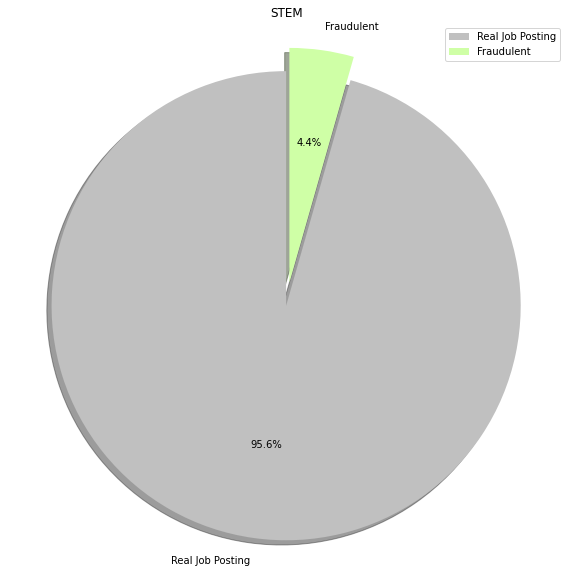

In [8]:
import matplotlib.pyplot as plt

stem_zero = df_stem['fraudulent'].value_counts()[0]
stem_one = df_stem['fraudulent'].value_counts()[1]
non_stem_zero = df_non_stem['fraudulent'].value_counts()[0]
non_stem_one = df_non_stem['fraudulent'].value_counts()[1]

labels = 'Real Job Posting', 'Fraudulent'
sizes = [stem_zero, stem_one]
explode = (0, 0.1)  

#add colors
colors = ['#C0C0C0','#CFFFA6']

fig1, ax1 = plt.subplots(figsize = (10, 10))
ax1.pie(sizes, explode=explode, colors=colors, labels = labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('STEM')
plt.legend()
plt.show()

# Differentiate categorical data and numerical data

In [9]:

df_num = df[['telecommuting','has_company_logo','has_questions','fraudulent','salary_range']]
df_cat = df[['title', 'location','company_profile', 'requirements','employment_type',
       'required_experience', 'required_education', 'industry', 'function']]

# Checking for Outliers in numerical data to minimise overfitting


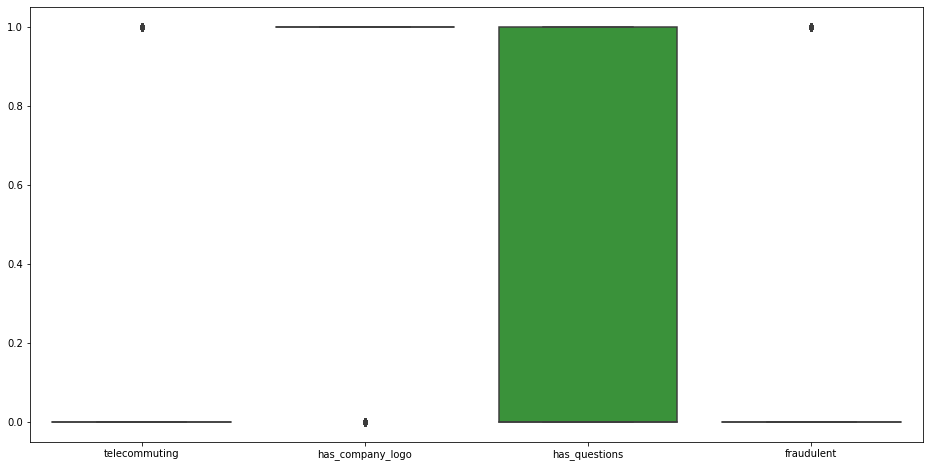

In [10]:
plt.figure(figsize=[16,8])
sns.boxplot(data = df_num)
plt.show()

In [11]:
#Removing Outliers from columns
df_num = df_num[df_num['telecommuting'] < 0.9 ]
df_num = df_num[df_num['fraudulent'] < 0.9 ]
df_num = df_num[df_num['has_company_logo'] > 0.1 ]
df_num

,telecommuting,has_company_logo,has_questions,fraudulent,salary_range
0,0,1,0,0,NaN
1,0,1,0,0,NaN
2,0,1,0,0,NaN
3,0,1,0,0,NaN
4,0,1,1,0,NaN
...,...,...,...,...,...
17872,0,1,0,0,NaN
17873,0,1,0,0,NaN
17875,0,1,1,0,NaN
17876,0,1,1,0,NaN


In [12]:
df.dropna(axis= 0, how= 'any', inplace=True)


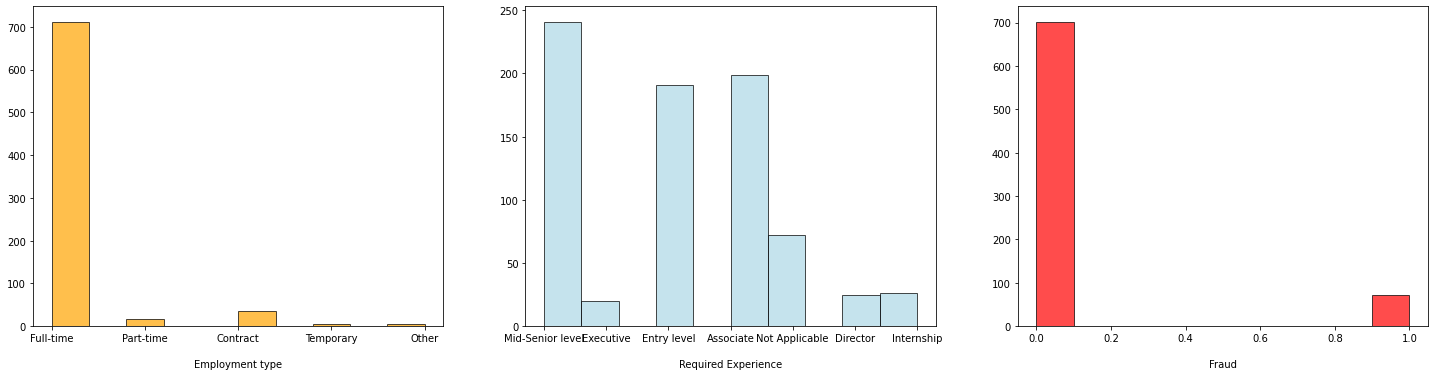

In [13]:
# Plots to see the distribution of the continuous features individually

plt.figure(figsize= (25,20))
plt.subplot(3,3,1)
plt.hist(df.employment_type, color='orange', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nEmployment type')

plt.subplot(3,3,2)
plt.hist(df.required_experience, color='lightblue', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nRequired Experience')

plt.subplot(3,3,3)
plt.hist(df.fraudulent, color='red', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nFraud')
plt.show()

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import feature_selection
from sklearn.impute import SimpleImputer

df['department'] = df['department'].fillna(df['department'].mode()[0])

data_cat_imp=SimpleImputer(strategy="constant",fill_value="Missing")
cat_imp_feature=["title","location","department","salary_range","company_profile","description","requirements","benefits",
                 "employment_type","required_experience","required_education","industry","function"]

# Filling the Numerical values through existing value
data_num_imp=SimpleImputer(strategy="constant",fill_value=None)
num_imp_feature =["job_id","telecommuting","has_company_logo","has_questions","fraudulent"]

# Transforming into column
data_imp_trans=ColumnTransformer([("data_cat_imp",data_cat_imp,cat_imp_feature),
                                 ("data_num_imp",data_num_imp,num_imp_feature)])

# Transforming and assigning the data
transformed_data=data_imp_trans.fit_transform(df)
transformed_data
#Transforming the data into data frame
df_job_transformed_data=pd.DataFrame(transformed_data,
                         columns=["title","location","department","salary_range","company_profile","description",
                                  "requirements","benefits", "employment_type","required_experience","required_education",
                                  "industry","function","job_id","telecommuting","has_company_logo","has_questions",
                                  "fraudulent"])

X_trans = df_job_transformed_data.drop("fraudulent",axis=1)
y_trans = df_job_transformed_data.fraudulent
y_trans=y_trans.astype('int')

X_trans.shape, y_trans.shape,X_trans.columns

# Instantation of One Hot Encoder for categorical data tarnsformatio into Numeric 
one_hot=OneHotEncoder()
clf_trans=ColumnTransformer([("one_hot",one_hot,cat_imp_feature)],remainder="passthrough")
X_trans_fin=clf_trans.fit_transform(X_trans)
np.array(X_trans_fin)

X_train,X_test,y_train,y_test=train_test_split(X_trans_fin,y_trans,test_size=0.25, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((580, 3563), (194, 3563), (580,), (194,))

In [15]:
from sklearn.ensemble import RandomForestClassifier
# Random forest
model_rfm=RandomForestClassifier(random_state=42)
model_rfm.fit(X_train,y_train)
y_pred_rfm = model_rfm.predict(X_test)
rfc_accuracy = model_rfm.score(X_test, y_test)

In [16]:
print(f"Fake Job Random Forest Model Classification  Accuracy : {rfc_accuracy*100:.2f}%")


Fake Job Random Forest Model Classification  Accuracy : 99.48%


## How many trees should we use in this Random Forest Algo?
## Let's tune this hyperparameter

In [19]:
n_trees = [10,15,30,40,50]
for i in n_trees:
    ran_for = RandomForestClassifier(n_estimators=i)
    ran_for.fit(X_train,y_train)
    pred = ran_for.predict(X_test)
    
    print('n of trees: {}'.format(i))
    #Each time of prediction,the accuracy is measured
    correct_pred = 0
    for j,k in zip(y_test,pred):
        if j == k:
            correct_pred += 1
    print('correct predictions: {}'.format(correct_pred/len(y_test) *100))
    print('-------------------------------------------------------------------')

n of trees: 10
correct predictions: 98.4536082474227
-------------------------------------------------------------------
n of trees: 15
correct predictions: 98.96907216494846
-------------------------------------------------------------------
n of trees: 30
correct predictions: 98.96907216494846
-------------------------------------------------------------------
n of trees: 40
correct predictions: 98.96907216494846
-------------------------------------------------------------------
n of trees: 50
correct predictions: 99.48453608247422
-------------------------------------------------------------------


Adding confusion matrix tells us something As the accuracy score of random forests show, its accuracy score increases as we suspected. However, the score strats to remain constant, and drop at some point. What does this imply? It tells us a number of tree (hyper-parameter) is needed consideration. Higher amount of trees may not the best solution. This is why confusion matries are attached, which give us very useful information. It is not necessary to pick 300 trees, but 50 or 100 tress are acceptable. Why? Obviously, it is hard to tell difference in accuracy score, true positive, false negative, true negative, and false negative.



# The visualisation below shows feature importance of fields in the dataset on the classification

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


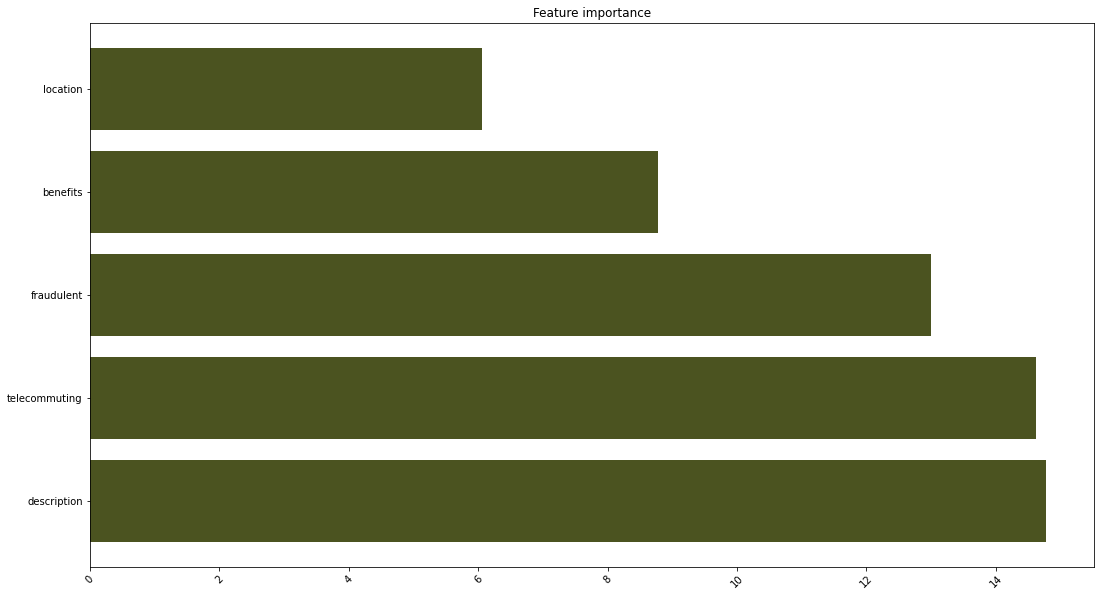

In [18]:
feature_dict=dict(zip((df.columns),list(model_rfm.feature_importances_)))

log_val = []
for i in feature_dict.values():
    log_val.append(np.log(i))

log_val = np.nan_to_num(log_val, neginf=0)
log_val = [i * (-1) for i in log_val]
names = list(feature_dict.keys())
dictionary = dict(zip(names, log_val))

sorted_dict = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse = True))
names = []
values = []
for k, v in sorted_dict.items():
    if v != -0.0:
        names.append(k)
        values.append(v)
        
plt.figure(figsize = (18, 10))
colors = ['#4b5320']
plt.barh(range(len(values)), values, tick_label=names, color = colors[0])
plt.xticks(rotation=45)
plt.title('Feature importance')
plt.show()

## Random Forest Algorithm


Random Forest is a well-known machine learning algorithm that uses the supervised learning method. In machine learning, it may be utilized for both classification and regression issues. It is based on ensemble learning, which is a method of integrating several classifiers to solve a complicated issue and increase the model's performance.

"Random Forest is a classifier that contains a number of decision trees on various subsets of a given dataset and takes the average to enhance the predicted accuracy of that dataset," according to the name. Instead than depending on a single decision tree, the random forest collects the forecasts from each tree and predicts the final output based on the majority votes of predictions.

In [20]:
from sklearn.naive_bayes import  MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score ,confusion_matrix ,classification_report

In [23]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [24]:
y_pred_nb = nb.predict(X_test)

In [25]:
accuracy_score(y_test,y_pred_nb)

0.8865979381443299

In [26]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [27]:
y_pred_dt = dt.predict(X_test)

In [28]:
accuracy_score(y_test,y_pred_dt)

0.9896907216494846

In [29]:
X_test[159]

<1x3563 sparse matrix of type '<class 'numpy.float64'>'
	with 17 stored elements in Compressed Sparse Row format>

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np

In [32]:
y=df.fraudulent
print(y.head())

6      0
15     0
23     0
98     1
102    0
Name: fraudulent, dtype: int64


In [33]:
X=df.drop('fraudulent',1)
print(X.head())

     job_id                                              title  \
6         7                              Head of Content (m/f)   
15       16                         VP of Sales - Vault Dragon   
23       24  Vice President, Sales and Sponsorship (Busines...   
98       99                                    IC&E Technician   
102     103                            Marketing Administrator   

              location          department   salary_range  \
6       DE, BE, Berlin          ANDROIDPIT    20000-28000   
15   SG, 01, Singapore               Sales  120000-150000   
23    US, CA, Carlsbad  Businessfriend.com  100000-120000   
98   US, , Stocton, CA        Oil & Energy   95000-115000   
102  GB, WAR, Coventry         Marketplace    15000-18000   

                                       company_profile  \
6    Founded in 2009, the Fonpit AG rose with its i...   
15   Jungle Ventures is the leading Singapore based...   
23   WDM Group is an innovative, forward thinking d...   
98  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [34]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (541, 17) (541,)
Test set: (233, 17) (233,)


In [35]:
input_text = ['general laborers us, ct, hartford elite environmental group llc. provides staffing services temporary employment opportunities wide range clients, business owners search employees, candidates search employment environmental, construction industry. elite environmental group currently hiring general laborers, construction, housekeeping, manufacturing associates temporary temporary hire positions, paying $9.00 - $13.00 per hour. you’re dependable looking work, contact elite environmental group today. job descriptionconstruction erect dismantle scaffolding, shoring, braces, traffic barricades, ramps, temporary structuresmanufacturing associate receive count stock items, record data manually using computer.general labor clean prepare construction sites eliminate possible hazards.pack unpack items stocked shelves stockrooms, warehouses, storage yards.housekeeper clean guest rooms common areasmark stock items using identification tags, stamps, electric marking tools, labeling equipment. ideal candidatesrelevant experience preferredreliable transportationcommitted safety timesexcellent attendance']

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [38]:
X_train_dtm = vect.transform(X_train)

In [44]:
df.title.value_counts()[:11]

Customer Service Representative                                  18
Systems Engineers/Network Administrators/Tiers I-III              8
Technical Support Associate                                       7
Sales Representative                                              7
Sales, Assistant Manager & Market Manager Positions Available     7
Sales Executive                                                   6
Marketing Manager                                                 5
Graduate Summer Work Program -- Limited Openings -- Apply Now     5
Marketing Associate                                               5
Systems Engineer                                                  5
Van Foreman / Driver - Class A                                    4
Name: title, dtype: int64

In [45]:
df[df.fraudulent == 1].title.value_counts()[:11]

Customer Service Representative    11
Call Center Representative I        4
Sales Representative                3
IC&E Technician                     2
Sales Professional- Mid Market      2
UST Testing Technician III          2
Credit and Collections Clerk        2
Payroll Clerk                       2
CALL CENTER REP                     2
Plant Operator                      2
Health + Safety Professional        2
Name: title, dtype: int64

In [46]:
df[df.fraudulent == 0].title.value_counts()[:11]

Systems Engineers/Network Administrators/Tiers I-III             8
Technical Support Associate                                      7
Sales, Assistant Manager & Market Manager Positions Available    7
Customer Service Representative                                  7
Sales Executive                                                  6
Marketing Associate                                              5
Graduate Summer Work Program -- Limited Openings -- Apply Now    5
Systems Engineer                                                 5
Marketing Manager                                                5
Van Foreman / Driver - Class A                                   4
Sales Representative                                             4
Name: title, dtype: int64

In [47]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [50]:
df['text'] = df['title'] + ' '+ df['location'] + ' ' + df['department'] + ' ' + df['company_profile'] + ' '+ df['description'] + ' ' + df['requirements'] + ' ' + df['benefits'] + ' ' + df['industry']

del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['employment_type']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']


KeyError: ignored

In [51]:
df.head()

,job_id,salary_range,telecommuting,has_company_logo,has_questions,fraudulent,text
6,7,20000-28000,0,1,1,0,"Head of Content (m/f) DE, BE, Berlin ANDROIDPI..."
15,16,120000-150000,0,1,1,0,"VP of Sales - Vault Dragon SG, 01, Singapore S..."
23,24,100000-120000,0,1,0,0,"Vice President, Sales and Sponsorship (Busines..."
98,99,95000-115000,0,1,1,1,"IC&E Technician US, , Stocton, CA Oil & Energy..."
102,103,15000-18000,1,1,0,0,"Marketing Administrator GB, WAR, Coventry Mark..."


In [52]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [53]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [54]:
stop_words = set(stopwords.words("english"))

In [56]:
df['text'] = df['text'].apply(lambda x:x.lower())

In [57]:
df['text'] = df['text'].apply(lambda x:' '.join([word for word in x.split() if word not in(stop_words)]))

In [59]:
df['text']

6        head content (m/f) de, be, berlin androidpit f...
15       vp sales - vault dragon sg, 01, singapore sale...
23       vice president, sales sponsorship (businessfri...
98       ic&e technician us, , stocton, ca oil & energy...
102      marketing administrator gb, war, coventry mark...
                               ...                        
17734    customer service representative us, tx, housto...
17759    customer service representative us, ny, new yo...
17813    customer service representative us, pa, philad...
17849    communication designer us, ca, san francisco d...
17865    portfolio development associate - paris & rest...
Name: text, Length: 774, dtype: object

In [66]:
X_test

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
1502,1503,Accounting Product Support Representative,"US, MI, Ann Arbor",Support,30000-50000,"ParishSOFT LLC (formerly Parish Systems, Inc.)...",Exciting opportunity to work with fast paced c...,Proficient computer skills with familiarity of...,Profit Sharing401k MatchingHealth and Dental i...,0,1,0,Full-time,Entry level,Associate Degree,Information Technology and Services,Customer Service
14560,14561,Full Stack Python Developer,"DE, BE, Berlin",R&D,48000-60000,RhodeCode provides the leading source code man...,"Every day millions of developers, project mana...",5+ years working as a Python web developerExpe...,"Comprehensive compensation package, including ...",0,1,0,Full-time,Associate,Bachelor's Degree,Computer Software,Information Technology
2981,2982,User Interface Engineer,"US, MA, Cambridge",Product Management,80000-100000,Pioneering advanced analytics vendor RapidMine...,Pioneering advanced analytics vendor RapidMine...,Experience in engineering applicationsDegree i...,RapidMiner is an Equal Opportunity Employer.We...,0,1,1,Full-time,Associate,Associate Degree,Computer Software,Design
4902,4903,Product Specialist / Blippbuilder Brain,"GB, LND, London",Blippbuilder,30000-40000,"As augmented reality jobs go, one at Blippar i...",This is an exciting creative and customer faci...,We are looking for individuals that are excite...,"Our bright, open, centrally located offices ar...",0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Training
1450,1451,Internship (Medical Affairs),"GR, ,",Medical,4500-4500,This initiative is being led by a very talente...,This is a 6-month full-time paid internship po...,"Bachelor's Degree of all majors (AEI, TEI, Col...",Working experience in leading corporationsHoli...,0,1,1,Full-time,Internship,Bachelor's Degree,Pharmaceuticals,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4125,4126,Technical Support Engineer - Mobile Augmented ...,"GB, LND, London",Engineering,25000-30000,"As augmented reality jobs go, one at Blippar i...",We are looking for awesome application support...,We are looking for someone with experience in ...,"Our bright, open, centrally located offices ar...",0,1,0,Full-time,Associate,Unspecified,Internet,Engineering
9276,9277,Senior Business Development Manager,"GB, , London",Sales and Business Development,70000-90000,MarketInvoice is one of the most high-profile ...,BACKGROUNDA senior sales and account managemen...,5-10 years sales experience in B2B solution sa...,Competitive salary plus uncapped commission ba...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Financial Services,Sales
7105,7106,Program Manager,"US, CA, Los Angeles",AGENCY CONFIDENTIAL,60000-75000,Envision Consulting conducts retained searches...,AGENCY is a nonprofit organization dedicated t...,Bachelor's degree from an accredited college o...,COMPENSATION AND BENEFITSSalary starts at $60...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Nonprofit Organization Management,Administrative
4009,4010,Associate Account Manager-DRAFT,"US, MI, Ann Arbor",Sales,30000-35000,"ParishSOFT LLC (formerly Parish Systems, Inc.)...",Exciting opportunity to work with fast paced c...,Proficient computer skills with familiarity of...,Profit Sharing401k MatchingHealth and Dental i...,0,1,0,Full-time,Entry level,Associate Degree,Information Technology and Services,Sales


ValueError: ignored